# Evaporating water from a dish
## Notebook Goals
The goal of this exercise is to model how much moisture is in the air as a function of time. Ideally, this will give me an estimate of how long a dish of water needs to be in a box until a desired saturation is achieved. I have two approaches, and I like the second one more. I end up having a first order ODE analagous to compound interest, except I'm reaching a saturation and fall off point.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sympy as smp
from scipy.misc import derivative

## First approach

In [72]:
t = np.linspace(1e-3, 1, 100000)

Ce = 1e-4 # ?
T = 270 # K
Sa = 20 # cm^2
nvo = 1 # mols
nt = 20 # mols
def Re(nv, t, Ce, T, Sa, nt):
    return Ce * ((T * Sa)+(nv/nt)*(1/T**2)) * t

Cc = 1e-1
def Rc(nv, t, Cc, T, Sa, nt):
    return -((Cc * (nv/nt) * Sa)/T) * t

def nv(nv, t, Ce, Cc, T, Sa, nt):
    return(nv + Re(nv, t, Ce, T, Sa, nt) + Rc(nv, t, Cc, T, Sa, nt))

In [73]:
y = [nvo]
for i, time_point in enumerate(t):
    y.append(nv(y[i], time_point, Ce, Cc, T, Sa, nt))
x = t
x = np.insert(x, 0, 0)

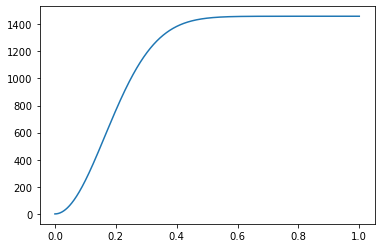

In [74]:
plt.plot(x,y)

## Second approach <-
Model: We have some $n_w$ amount of water at the surface of a bowl and $n_v$ amount of water in the air as vapor. I will be considering only the point of view of $n_v$, and therefore ask the questions:
1. How does water get added to the vapor?
1. How does water get subtracted from the vapor?

Well at any given time $t$, I will assume that 

$$n_v(t) = n_{v0}.$$ 

In a tiny time step of $\Delta t$ we can only gain vapor if some proportion of the water at the surface at the bowl $k n_w$ evaporated. Likewise, we can only lose vapor water if some proportion of $n_v$, $l n_v$, condensed back into the bowl. This would look like 

$$n_v(t+\Delta t) = n_v(t) + \Delta t(kn_w - ln_v(t)).$$

Here, my fun assumption is that $kn_w$ is a constant I'll call $E$! $E$ represents the rate of liquid evaporting (as opposed to $k n_w\Delta t$ which would be the number of water molecules that left the water surface in the span of $\Delta t$) and it would not depend on time at all. Its only dependancies would be on the surface area ($S_A$), temperature ($T$), and some liquid specific volitility properties ($C$) --- $E = S_A T C$. $E \in \mathbb{R}$ and means the number of moles that leave due to evaporation.

The $ln_v(t)$ term is a bit less solid in my mind. $n_v(t)$ is definetely a function of time, but the proportionality constant $l$ I'm a bit unsure of what it should depend on. My current rationale is that 
1. The hotter the temperature, the smaller $l$ should be $l \propto \frac{1}{T}$
1. The more surface area of water, the more water will try to condense $l \propto S_A$
1. And some reliance on how volitile the liquid is $l \propto \frac{1}{C}$
1. Lastly, because $l$ is a proportion, $0<l<1$.


To summarize
1. Initial condition $n_v(t) = n_{v0}$ mols of $H_2O$ in the air
1. Change over time $\frac{dn_v}{dt} = E-ln_v(t)$ mols/second

In [307]:
360 * 24

8640

In [319]:
t = np.linspace(0, 8640, 10000)

nv0 = 0
nv = [nv0]
l = 1e-3 # 0<l<1
E = 1/100
def dnvdt(nv, E, l):
    return(E-l*nv)

In [320]:
for i in range(1,len(t)):
    time_point = t[i]
    dnvdt_value = dnvdt(nv[i-1], E, l)
    nv.append(nv[i-1] + dnvdt_value)
    # print(f't: {time_point}\nE: {E}\nl: {l}\ndnvdt_value: {dnvdt_value}')

prop_sat = 0.6
error_margin = 1e-3
try:
    print(f'Saturates at: {t[np.where(np.array(nv) >= ((E/l - error_margin)))[0][0]]/360} hr')
except:
    print("Doesn't saturate")
try:
    print(f'Satisfies at: {t[np.where(np.array(nv) >= (prop_sat*(E/l - error_margin)))[0][0]]/360} hr')
    time_till_satisfied = t[np.where(np.array(nv) >= (prop_sat*(E/l - error_margin)))[0][0]]/360
except:
    print("Doesn't satisfy")

Saturates at: 22.096609660966095 hr
Satisfies at: 2.1986198619861983 hr


Text(4.198619861986199, 6.1, '(2.2,6.0) 60.0% sat')

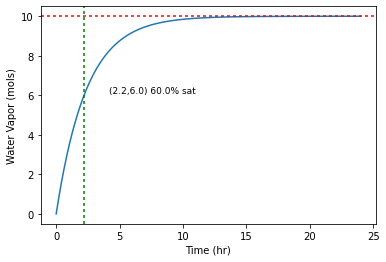

In [321]:
# time_till_satisfied = t[np.where(np.array(nv) >= (prop_sat*(E/l - error_margin)))[0][0]]

plt.plot(t/360, nv)
plt.ylabel("Water Vapor (mols)")
plt.xlabel("Time (hr)")
plt.axhline(E/l, color = 'red', dashes=[1,0,1])
plt.axvline(time_till_satisfied, color='green', dashes=[1,0,1])
plt.text(time_till_satisfied+2, (prop_sat * E/l)+0.1, f'({round(time_till_satisfied,2)},{round((prop_sat * E/l),2)}) {prop_sat*100}% sat', fontsize=9)

### Summary
1. Saturation (max water in the atmosphere) occurs at $\frac{E}{l}$
1. Time of saturation can be found numerically by looking for when $n_v \propto \frac{E}{l}$ within a certain threshold
1. Relative humidity would probably be calculated by $\frac{ln_v}{E}$

### Future directions
1. It would be interesting to iron out all the units and eventually solve for a 'relative humidity' value because that is what is measurable. Should not be to difficult considering $\frac{E}{l}$ turned out to be saturation.

1. I should also symbolically solve the ODE. I shouldn't be too tough, just need to remember the formulas.

1. It would be nice to practice sympy and turn all these functions into symbols. Who knows, maybe it could solve the ODE for me in python!

1. I didn't read [Chen Zhang's Modeling and Simulation of Humidity Inside Sealed Boxes](https://www.researchgate.net/publication/232616036_Modeling_and_Simulation_of_Humidity_Inside_Sealed_Boxes) paper too carefully, but it might be beneficial to look over his work and look at the equations he cites.